#### Import library

In [6]:
import torch as tc # Import PyTorch for deep learning.
import torch.nn as nn  # Import the neural network module from PyTorch.
import torch.nn.functional as F  # Import the functional module from PyTorch for activation functions.
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pandas as pd
import statistics
import numpy as np  # Import NumPy for numerical operations.
from sklearn.preprocessing import OneHotEncoder # Import one-hot encoding to process the catagorical data
import matplotlib.pyplot as plt  # Import Matplotlib for plotting.
import time
from matplotlib_inline.backend_inline import set_matplotlib_formats  # Import display for rendering plots.
set_matplotlib_formats('svg')  # Set the plot format to SVG.
np.set_printoptions(suppress=True) # setting the printing options
tc.set_printoptions(profile="full")

#### 0. Custom functions

In [7]:
# Load the csv data from the same directory.
# Return the data in numpy array format
def loadData(file_name: str):
    # Import data from the Excel file by using pandas
    # https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
    data = pd.read_csv(file_name, header="infer")
    return data


# Apply one-hot encoding to the dataset
# np.get_dummies have the same function as sklearn.OneHotEncoder()
def oneHotEncode(data: pd.arrays, data_class: list):
    one_hot_encoded_data = pd.get_dummies(data, columns = data_class, dtype=float)
    return one_hot_encoded_data

# Split the data to dataset and class labels
def splitDataLabels(data: np.ndarray, index: int):
    data = np.asarray(data, dtype=float)
    labels = data[:, index]
    dataset = np.delete(data, index, 1)
    return np.asarray(dataset, dtype=float), np.asarray(labels, dtype=int)


# Calculate mean centered method to the input data matrax
# return mean centered matrix and print the procedures
def scaleData(data: np.ndarray):
    # Change all the data type to float
    X = np.asarray(data, dtype=np.float64)
    # Calculate the mean value of each column for the matrix
    X_mean = np.mean(X, axis=0)
    # Calculate the standard deviation value of each column for the matrix
    X_std = np.std(X, axis=0)
    X_std[X_std==0] = 1
    # Calculate the scaled matrix.
    X_mc = (X - X_mean)/X_std
    return X_mc, X_mean, X_std


# Shuffle the data by using the magical number 42,
# then separate the data by 70% for training, 30% for testing
def trainTestSplit(data, labels, testsize: float, seed:int):
    training_data, testing_data, training_labels, testing_labels \
        = train_test_split(data,labels,test_size=testsize,train_size=1-testsize,random_state=seed)

    return training_data, testing_data, training_labels, testing_labels


# transform dataset to dataloder for miniBatch operation
def dataLoaderCovert(trainData, trainLabels, testData, testLabels, batchSize):

    #check if input dataset is tentor type
    trainData, trainLabels, testData, testLabels = \
        [tc.tensor(data) if not isinstance(data, tc.Tensor)
         else data for data in [trainData, trainLabels, testData, testLabels]]

    train_dataset = TensorDataset(trainData, trainLabels)
    test_dataset  = TensorDataset(testData, testLabels)

    train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

    return train_loader, test_loader


# Create a neural network model with customizable:
# hidden units, layers, optimizer, and learning rate
def customNet(nUnits, nLayers, nVar, nClasses, optimizerAlgo, learningRate):
    """
    input: #units, #layers, #variables, #classes, ['optimizer algorithm'], learning rate
    return: annModel, loss function, optimizer algorithm
    """
    # Define a neural network class with customizable：
    # hidden units, layers, input variables, and classes
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Create a dictionary to store the layers.
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers

            # Input layer.
            self.layers['input'] = nn.Linear(nVar, nUnits)

            # Hidden layers.
            for i in range(nLayers):
                self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

            # Output layer.
            self.layers['output'] = nn.Linear(nUnits, nClasses)

        # Forward pass through the network.
        def forward(self, x):

            # Input layer (with ReLU activation).
            x = F.relu(self.layers['input'](x))

            # Hidden layers with ReLU activation.
            for i in range(self.nLayers):
                x = F.relu(self.layers[f'hidden{i}'](x))

            x = self.layers['output'](x)  # Output layer.
            return x

    # input "annModel" is a customized neural network
    net = qwertyNet()

    # define loss function
    lossFunc = nn.CrossEntropyLoss()

    # select optimizer algorithm
    optiFunc = getattr(tc.optim, optimizerAlgo)

    # We initialize the optimizer with the model parameters
    # and a specified learning rate
    optimizer = optiFunc(net.parameters(), lr=learningRate)

    return net, lossFunc, optimizer


# Create function to train the ANN model. This function should use with the
# model that returns "ANN architecture", "loss function", and "optimizer"
def trainNet(annModel, lossFunc, optimizer, train_loader, test_loader, epochs):
    """
    input: annModel, lossFunc, optimizer, train_loader, epochs
    output: train accuracy, test accuracy, losses, trained model
    """
    # initialize losses
    losses   = tc.zeros(epochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        annModel.train()
        # loop over training data batches
        batchAcc  = []
        batchLoss = []

        for X, y in train_loader:

            # forward pass and loss
            yHat = annModel(X)
            loss = lossFunc(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = tc.argmax(yHat,axis=1) == y # booleans (false/true)
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*tc.mean(matchesNumeric) # average and x100
            batchAcc.append(accuracyPct) # add to list of accuracies
        # end of batch loop...

        # get average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        annModel.eval()
        X, y = next(iter(test_loader))
        with tc.no_grad():
            yHat = annModel(X)

        # get average test accuracy
        testAcc.append(100*tc.mean((tc.argmax(yHat,axis=1)==y).float()))
    # end epochs

    return trainAcc, testAcc, losses, annModel


# Creat function to get final accuracy for training and testing datasets
def finalAcc(finalANN, train_data, train_labels, test_data, test_labels):
    # Final forward pass
    train_predictions = finalANN(train_data)
    pred_trainlabels = tc.argmax(train_predictions, axis=1)
    train_accuracy = 100 * tc.mean((pred_trainlabels == train_labels).float())

    # Final tesing pass
    test_predictions = finalANN(test_data)
    pred_testlabels = tc.argmax(test_predictions, axis=1)
    test_accuracy = 100 * tc.mean((pred_testlabels == test_labels).float())

    return train_accuracy, test_accuracy


# Plot reuslts
def pltResults(net, data, labels, nClasses, optimizerType, losses, trainAcc, testAcc):
    """
    input: net, data, labels, nClasses, optimizerType, losses, trainAcc, testAcc
    output: 3 plots including loss function, accuracy functions, accuracy functions
    """
    # compute accuracy over entire dataset (train+test)
    yHat = net(data)
    predictions = tc.argmax(yHat,axis=1)
    accuracy = (predictions == labels).float()
    totalAcc = tc.mean(100*accuracy).item()

    # and accuracy by group
    accuracyByGroup = np.zeros(nClasses)
    for i in range(nClasses):
        accuracyByGroup[i] = 100*tc.mean(accuracy[labels==i])

    # create the figure
    fig, ax = plt.subplots(1,3,figsize=(12,3))

    # plot the loss function
    ax[0].plot(losses.detach())
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_title(f'{optimizerType}: Losses')

    # plot the accuracy functions
    ax[1].plot(trainAcc,label='Train')
    ax[1].plot(testAcc,label='Test')
    ax[1].set_ylabel('Accuracy (%)')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title(f'{optimizerType}: Total accuracy: {totalAcc:.2f}%')
    ax[1].legend()

    # plot overall accuracy by group
    ax[2].bar(range(nClasses),accuracyByGroup)
    ax[2].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
    ax[2].set_xticks(range(nClasses))
    ax[2].set_xlabel('Group')
    ax[2].set_ylabel('Accuracy (%)')
    ax[2].set_title(f'{optimizerType}: Accuracy by group')


### 1. Load data

In [8]:
# Load the csv data from the same directory.
# data = loadData("StarTypes.csv")
path = "data.csv"
data = pd.read_csv(path)
# The star color data is not unified. Change all the string to lower case, remove extra spaces
data['Star color'] = data['Star color'].str.lower().str.strip().str.replace(' ', '-')

### 2. Data processing

In [9]:
# Apply one-hot encoding
oheData = oneHotEncode(data, ['Star color'])
oheData = oneHotEncode(oheData, ['Spectral Class'])

# Split data into attributes and labels
labelidx = data.columns.get_loc('Star type')
attData, totlabels = splitDataLabels(oheData, labelidx)

# Split into training and testing
trainData, testData, train_labels, test_labels = trainTestSplit(attData, totlabels, 0.2, 42)

# Z-score normalization
trainData, trainMean, trainStd = scaleData(trainData)
testData = (testData - trainMean) / trainStd

# Convert to tensor
train_data = tc.tensor(trainData).float()
train_labels = tc.tensor(train_labels).long()

# Keep 20% as reserved test data untouched for final model evaluation
test_data_reserved = tc.tensor(testData).float()
test_labels_reserved = tc.tensor(test_labels).long()

# Apply K-Fold split on training data set
k = 4
kf = KFold(n_splits=k, random_state=None, shuffle=False)

### 3. Hyperparameters fine tuning

#### 3.1 Test optimizer algorithm

For Fold 0 dataset:
best learning rate with SGD optimizer is around 0.1;
compute time is 47.296875 seconds


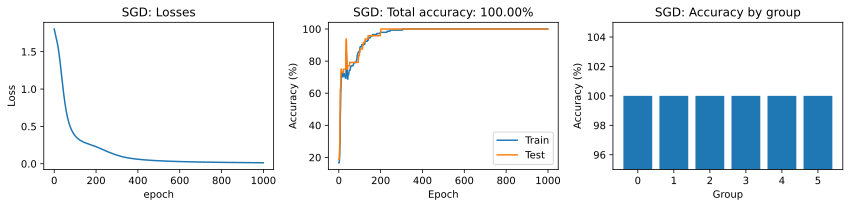

For Fold 0 dataset:
best learning rate with RMSprop optimizer is around 0.01;
compute time is 53.4375 seconds


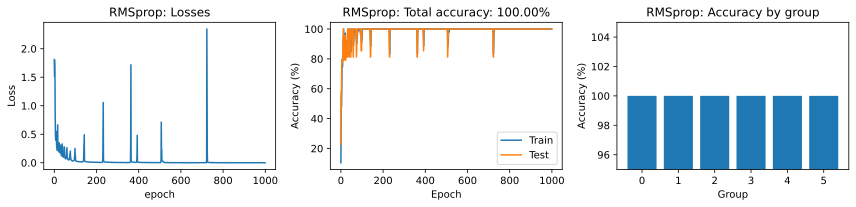

For Fold 0 dataset:
best learning rate with Adam optimizer is around 0.01;
compute time is 99.90625 seconds


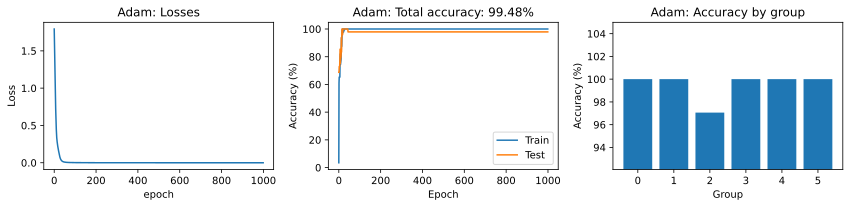

For Fold 0 dataset:
best learning rate with Adadelta optimizer is around 0.1;
compute time is 122.890625 seconds


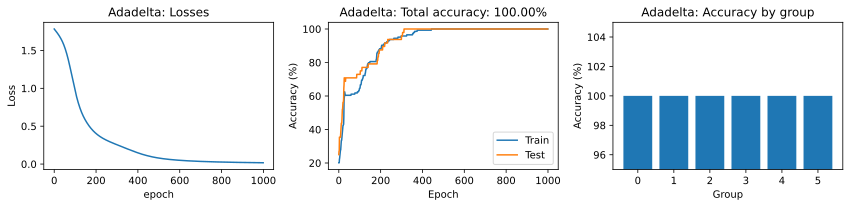

For Fold 1 dataset:
best learning rate with SGD optimizer is around 0.1;
compute time is 106.578125 seconds


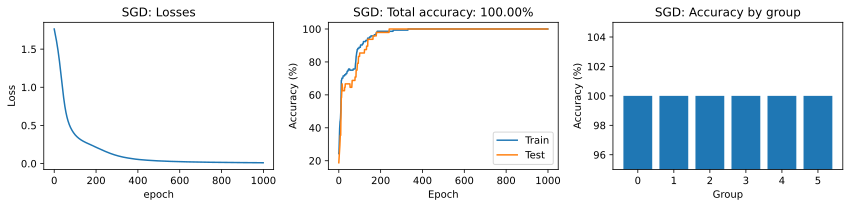

For Fold 1 dataset:
best learning rate with RMSprop optimizer is around 0.01;
compute time is 113.6875 seconds


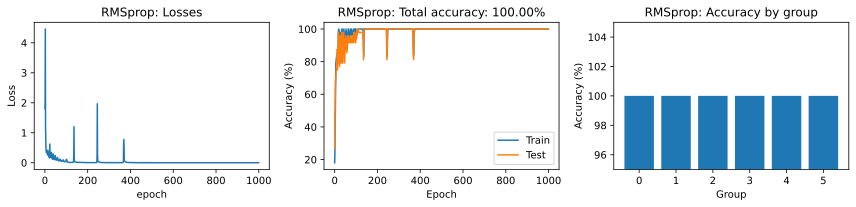

For Fold 1 dataset:
best learning rate with Adam optimizer is around 0.01;
compute time is 122.75 seconds


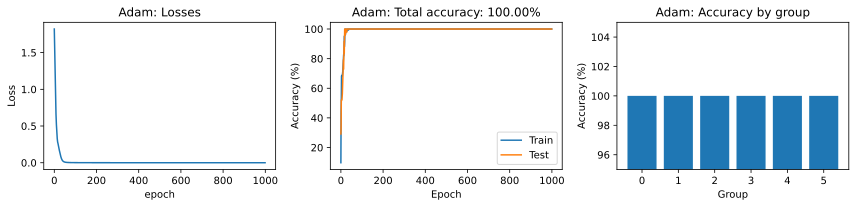

For Fold 1 dataset:
best learning rate with Adadelta optimizer is around 0.1;
compute time is 119.671875 seconds


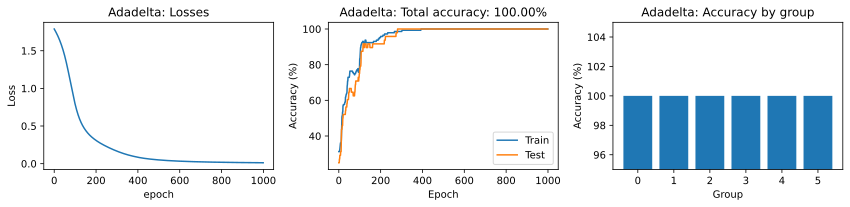

For Fold 2 dataset:
best learning rate with SGD optimizer is around 0.1;
compute time is 105.640625 seconds


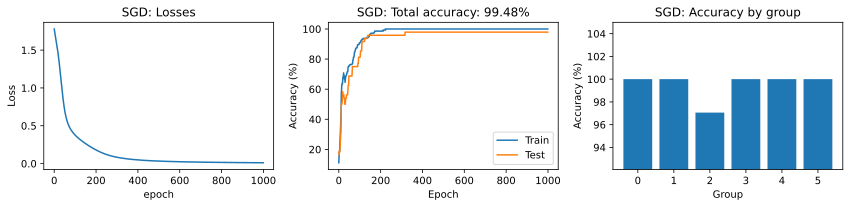

For Fold 2 dataset:
best learning rate with RMSprop optimizer is around 0.01;
compute time is 115.5 seconds


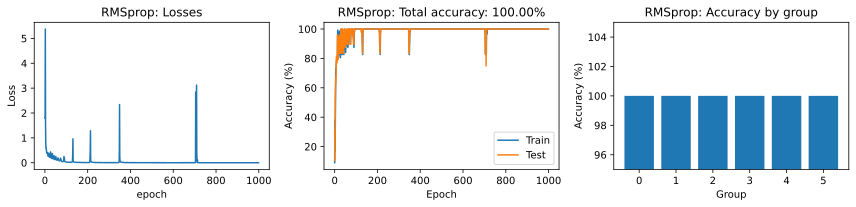

For Fold 2 dataset:
best learning rate with Adam optimizer is around 0.01;
compute time is 123.9375 seconds


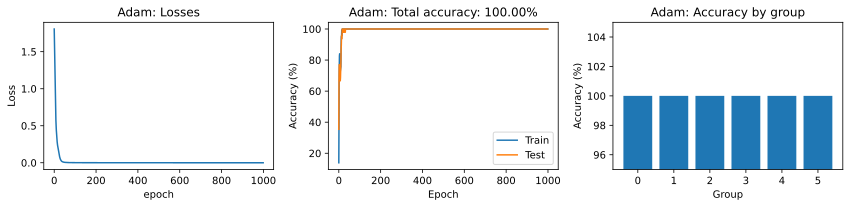

For Fold 2 dataset:
best learning rate with Adadelta optimizer is around 1;
compute time is 119.09375 seconds


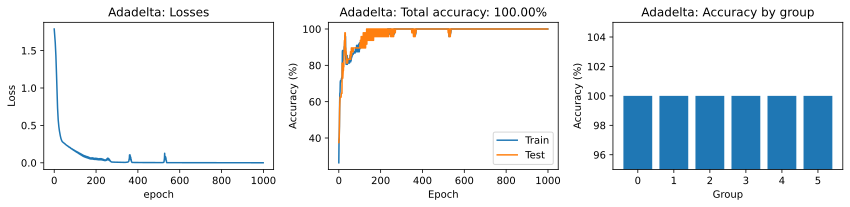

For Fold 3 dataset:
best learning rate with SGD optimizer is around 0.1;
compute time is 105.96875 seconds


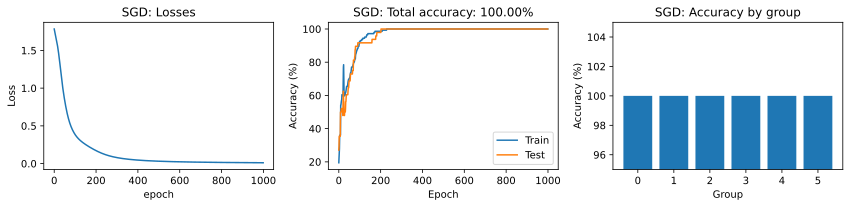

For Fold 3 dataset:
best learning rate with RMSprop optimizer is around 0.01;
compute time is 114.84375 seconds


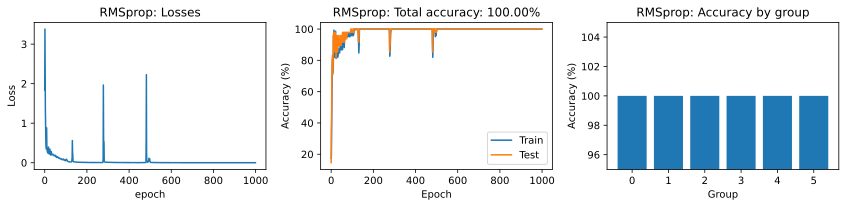

For Fold 3 dataset:
best learning rate with Adam optimizer is around 0.01;
compute time is 125.140625 seconds


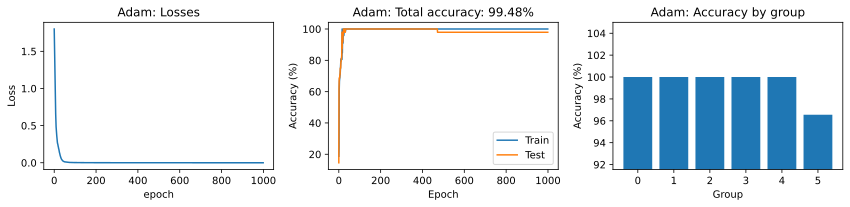

For Fold 3 dataset:
best learning rate with Adadelta optimizer is around 0.1;
compute time is 121.671875 seconds


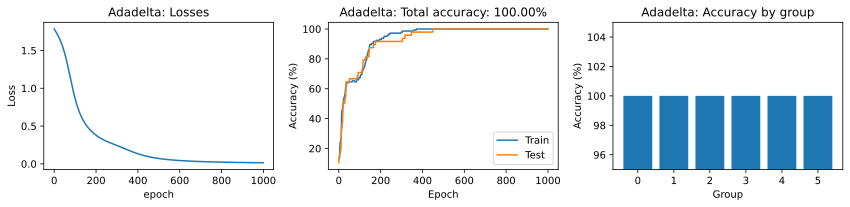

In [13]:
# Test on three different optimizer algorithms: SGD, RMSprop, Adam
optiAlgos = ['SGD', 'RMSprop', 'Adam', 'Adadelta']

# Setup epochs and lr for demo run
epochs = 1000
lrRange = [0.01, 0.1, 1]

# initial setup for demo run
nClasses = data['Star type'].nunique()
nVar = train_data.shape[1]
nUnitDemo = 64
nLayersDemo = 1


# Apply K-Flod CV for the training process
for foldi, (train_index, dev_index) in enumerate(kf.split(train_data)):

    # X is feature matrix, y is label vector, dev is validation set
    X_train, X_dev = train_data[train_index], train_data[dev_index]
    y_train, y_dev = train_labels[train_index], train_labels[dev_index]
    # transform to data loader
    train_loader, test_loader = dataLoaderCovert(X_train, y_train, X_dev, y_dev, X_train.shape[0])

    # test on three different optimizer algorithms
    for typei in range(len(optiAlgos)):

        # Start the timer to measure computation time
        computetime = 0
        starttime = time.process_time()

        # Compare and update model with best testing accuracy among learning rates
        bestAcc = 0
        bestAccT = tc.empty(0)

        # check typical learning rate values [0.01, 0.5, 0.1]
        for lri, lrvalue in enumerate(lrRange):

            # train the model
            netDemo, lossFuncDemo, optimizerDemo = customNet(
                nUnitDemo, nLayersDemo, nVar, nClasses, optiAlgos[typei], lrvalue)

            trainAcc, testAcc, losses, trainedNet = trainNet(
                netDemo, lossFuncDemo, optimizerDemo, train_loader, test_loader, epochs)

            _, finalTestAcc = finalAcc(trainedNet, X_train, y_train, X_dev, y_dev)

            # update the model with best testing accuracy
            if bestAcc < int(finalTestAcc):
                bestAcc = int(finalTestAcc)
                bestAccT = testAcc
                besttrainAcc = trainAcc
                bestLr = lrvalue
                bestLosses = losses
                bestNet = trainedNet

        # Record the computation time
        comptime = time.process_time() - starttime

        # print\plot results
        print(f'For Fold {foldi} dataset:'
              f'\nbest learning rate with {optiAlgos[typei]} optimizer is around {bestLr};'
              f'\ncompute time is {comptime} seconds')
        # pltResults(bestNet, train_data, train_labels, nClasses, optiAlgos[typei],
        #            bestLosses, besttrainAcc, bestAccT)
        # net, data, labels, nClasses, optimizerType, losses, trainAcc, testAcc
        """
        input: net, data, labels, nClasses, optimizerType, losses, trainAcc, testAcc
        output: 3 plots including loss function, accuracy functions, accuracy functions
        """
        # compute accuracy over entire dataset (train+test)
        yHat = bestNet(train_data)
        predictions = tc.argmax(yHat,axis=1)
        accuracy = (predictions == train_labels).float()
        totalAcc = tc.mean(100*accuracy).item()

        # and accuracy by group
        accuracyByGroup = np.zeros(nClasses)
        for i in range(nClasses):
            accuracyByGroup[i] = 100*tc.mean(accuracy[train_labels==i])

        # create the figure
        fig, ax = plt.subplots(1,3,figsize=(12,3))

        # plot the loss function
        ax[0].plot(bestLosses.detach())
        ax[0].set_ylabel('Loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_title(f'{optiAlgos[typei]}: Losses')

        # plot the accuracy functions
        ax[1].plot(besttrainAcc,label='Train')
        ax[1].plot(bestAccT,label='Test')
        ax[1].set_ylabel('Accuracy (%)')
        ax[1].set_xlabel('Epoch')
        ax[1].set_title(f'{optiAlgos[typei]}: Total accuracy: {totalAcc:.2f}%')
        ax[1].legend()

        # plot overall accuracy by group
        ax[2].bar(range(nClasses),accuracyByGroup)
        ax[2].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
        ax[2].set_xticks(range(nClasses))
        ax[2].set_xlabel('Group')
        ax[2].set_ylabel('Accuracy (%)')
        ax[2].set_title(f'{optiAlgos[typei]}: Accuracy by group')
        plt.tight_layout()
        plt.show()


Result discussion:  
In the initial phase of our analysis, we evaluated the performance of three optimization algorithms: "SGD," "RMSprop," and "Adam." We employed K-fold cross-validation on the training dataset, and from the results plotted for all four folds, we observed that all three algorithms achieved good overall accuracy. However, "Adam" optimizer demonstrated the fastest convergence and stability. As a result, we have selected the "Adam" optimizer with a learning rate of approximately 0.01 for our task.

#### 3.2 Test learning rate

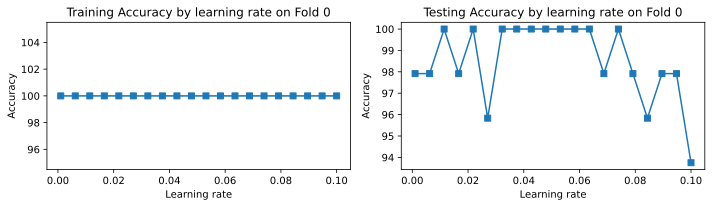

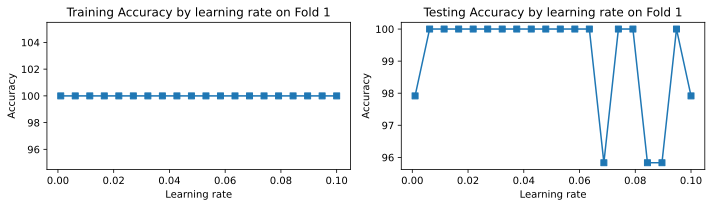

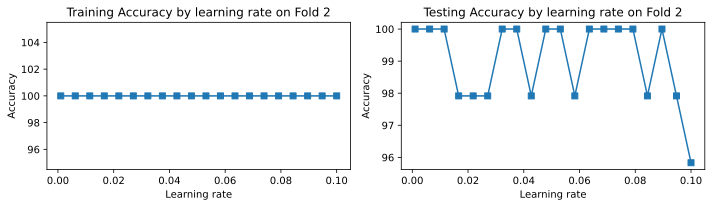

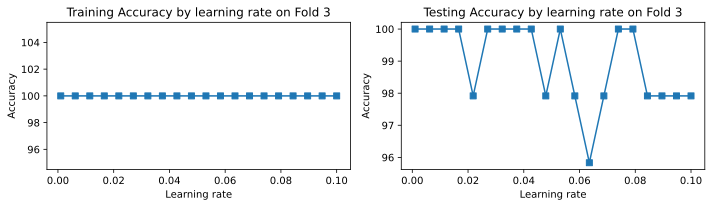

[2 3 4 2 2 2 4 4 3 3 4 2 3 1 4 3 0 1 1 0]


In [ ]:
# Test on learning rate around 0.01
learningrates = np.linspace(.001,0.1,20)
epochsLr = 800

allTestAcc = np.zeros((k+1, len(learningrates)))
allTestAcc[0, :] = np.reshape(learningrates, -1)

# Apply K-Flod CV for the training process
for foldi, (train_index, dev_index) in enumerate(kf.split(train_data)):

    # X is feature matrix, y is label vector, dev is validation set
    X_train, X_dev = train_data[train_index], train_data[dev_index]
    y_train, y_dev = train_labels[train_index], train_labels[dev_index]
    # transform to data loader
    train_loader, test_loader = dataLoaderCovert(X_train, y_train, X_dev, y_dev, X_train.shape[0])

    # initialize
    trainaccByLR = []
    testaccByLR = []

    # the loop
    for lri, lrvalue in enumerate(learningrates):

        # train the model
        netLr, lossFuncDemo, optimizerDemo = customNet(
          nUnitDemo, nLayersDemo, nVar, nClasses, 'Adam', lrvalue)

        _, _, _, trainedNetLr = trainNet(
          netLr, lossFuncDemo, optimizerDemo, train_loader, test_loader, epochsLr)

        trainAccLr, testAccLr = finalAcc(trainedNetLr, X_train, y_train, X_dev, y_dev)

        # store the results
        trainaccByLR.append(trainAccLr)
        testaccByLR.append(testAccLr)

        # store all test accuracy and lr values
        allTestAcc[foldi+1, lri] = testAccLr

    # plot the results
    fig,ax = plt.subplots(1,2,figsize=(10,4))

    ax[0].plot(learningrates,trainaccByLR,'s-')
    ax[0].set_xlabel('Learning rate')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title(f'Training Accuracy by learning rate on Fold {foldi}')

    ax[1].plot(learningrates,testaccByLR,'s-')
    ax[1].set_xlabel('Learning rate')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title(f'Testing Accuracy by learning rate on Fold {foldi}')
    plt.tight_layout()
    plt.show()


In [ ]:
# find optimal learning rate based on all 4 k-fold training results
freq = np.array(np.sum(allTestAcc == 100, axis=0))
indices = np.where(freq == np.max(freq))[0]

learning_rate = learningrates[indices]

print(learning_rate)

[0.01142105 0.03226316 0.03747368 0.05310526 0.07394737]


Result Discussion:

Among the five learning rate values tested, all resulted in 100% accuracy across all four K-fold datasets. This exceptional level of accuracy suggests that the choice of learning rate might not be the primary factor influencing the model's performance. It's important to further investigate this and assess if other factors are at play.

For the purpose of model simplicity and avoiding potential overfitting, we have selected a learning rate of 0.05 as it performed well in this experiment. However, it's advisable to conduct additional experiments and analyses to understand the model's behavior further and validate these results in different contexts.

#### 3.3 Test epochs

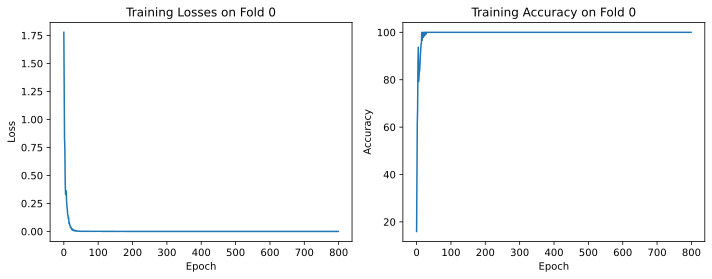

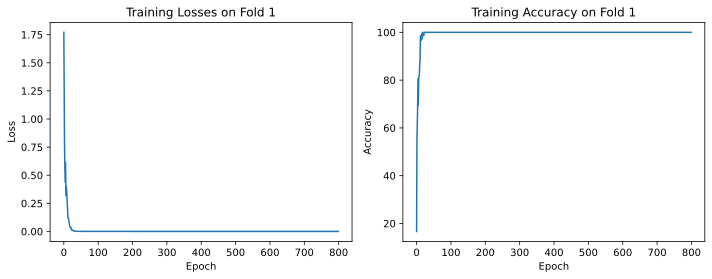

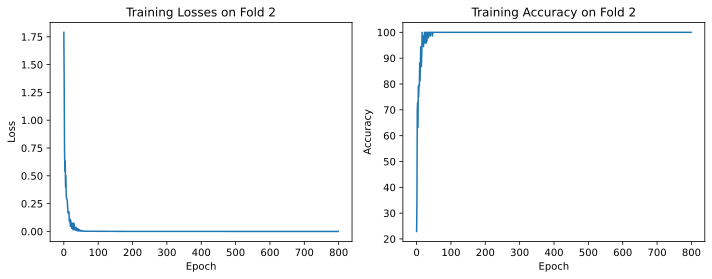

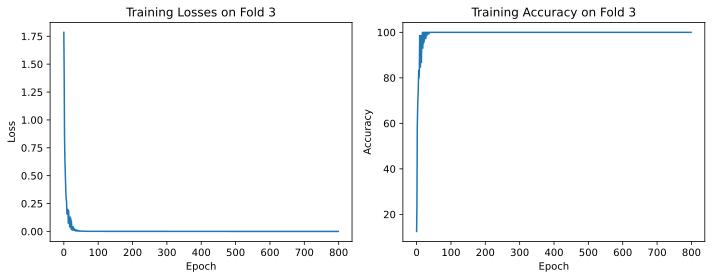

In [ ]:
# Already selected hypeparameters
learning_rate = 0.05
# Epochs for testing
epochsTest = 800


# Apply K-Flod CV for the training process
for foldi, (train_index, dev_index) in enumerate(kf.split(train_data)):

    # X is feature matrix, y is label vector, dev is validation set
    X_train, X_dev = train_data[train_index], train_data[dev_index]
    y_train, y_dev = train_labels[train_index], train_labels[dev_index]
    # transform to data loader
    train_loader, test_loader = dataLoaderCovert(X_train, y_train, X_dev, y_dev, X_train.shape[0])

    # train the model
    netEpoch, lossFuncDemo, optimizerDemo = customNet(
        nUnitDemo, nLayersDemo, nVar, nClasses, 'Adam', learning_rate)

    trainAcc, _, losses, _ = trainNet(
        netEpoch, lossFuncDemo, optimizerDemo, train_loader, test_loader, epochsTest)

    # Create subplots for losses and accuracy.
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Plot training losses.
    ax[0].plot(losses)
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_title(f'Training Losses on Fold {foldi}')

    # Plot ongoing accuracy during training.
    ax[1].plot(trainAcc)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title(f'Training Accuracy on Fold {foldi}')

    plt.tight_layout()
    plt.show()

Result Discussion:

The model have a fairly quick convergence through all K-fold CV dataset, pick 350 epochs for higher efficiency

#### 3.4 Test mini-batch

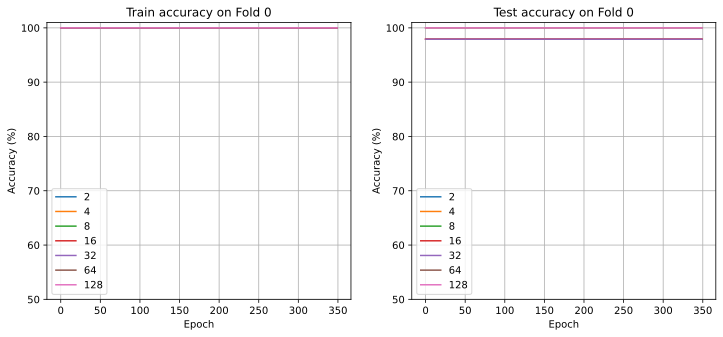

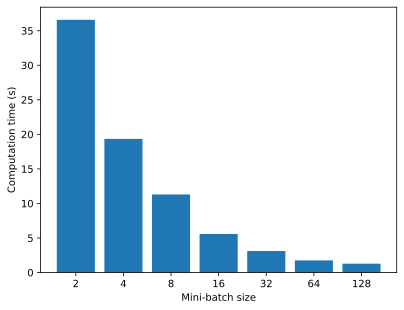

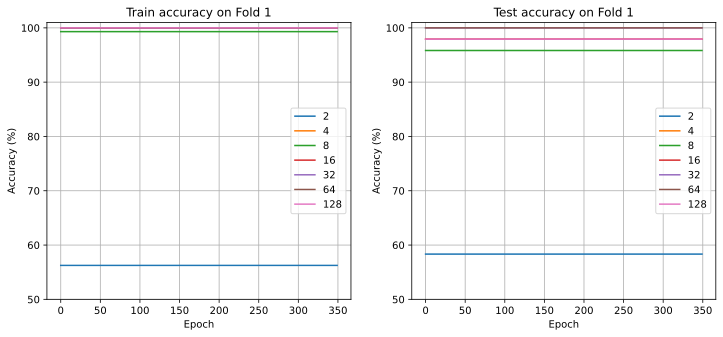

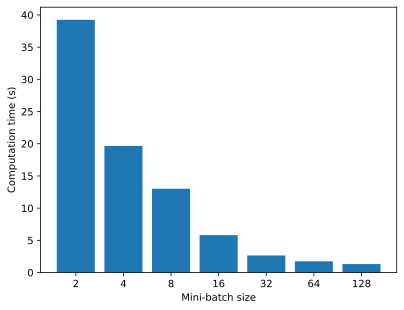

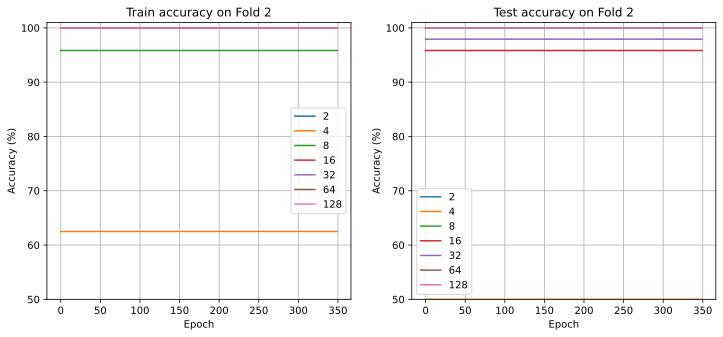

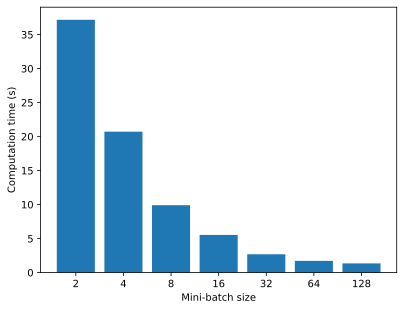

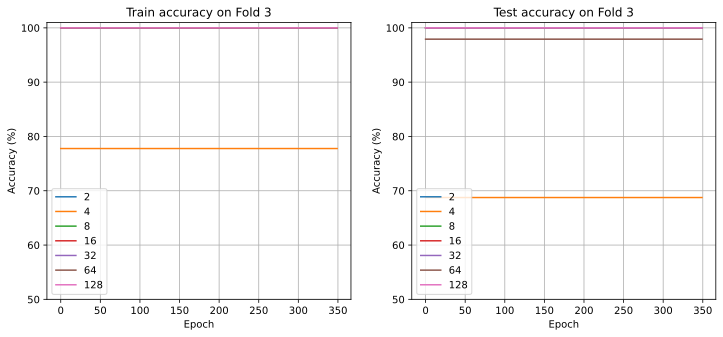

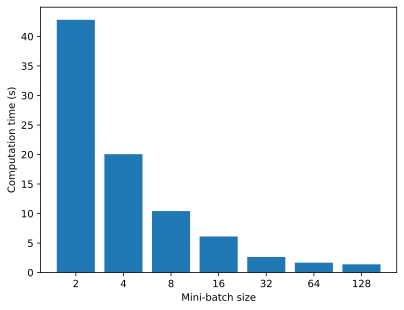

In [ ]:
# Aleady selected hypeparameters
learning_rate = 0.05
epochs = 350
optimizer = 'Adam'

# Define a range of batch sizes as powers of 2 from 2^1 to 2^6.
batchsizes = 2**np.arange(1, 8)

# Apply K-Flod CV for the training process
for foldi, (train_index, dev_index) in enumerate(kf.split(train_data)):

    # X is feature matrix, y is label vector, dev is validation set
    X_train, X_dev = train_data[train_index], train_data[dev_index]
    y_train, y_dev = train_labels[train_index], train_labels[dev_index]

    # Initialize empty matrices to store training and test accuracies for different batch sizes and time.
    accuracyResultsTrain = np.zeros((epochs,len(batchsizes)))
    accuracyResultsTest  = np.zeros((epochs,len(batchsizes)))
    comptime = np.zeros(len(batchsizes))

    # Loop over different batch sizes.
    for bi in range(len(batchsizes)):
        # Start the timer to measure computation time
        starttime = time.process_time()

        # Create a data loader object for training with the current batch size.
        train_loader, test_loader = dataLoaderCovert(X_train, y_train, X_dev, y_dev, int(batchsizes[bi]))

        # Build the model
        netMiniBatch, lossFuncDemo, optimizerDemo = customNet(
            nUnitDemo, nLayersDemo, nVar, nClasses, optimizer, learning_rate)

        # Train the model
        _, _, _, trainedNetMb = trainNet(
            netMiniBatch, lossFuncDemo, optimizerDemo, train_loader, test_loader, epochs)

        # Get overal accuracy
        trainAccMb, testAccMb = finalAcc(trainedNetMb, X_train, y_train, X_dev, y_dev)

        # Store the training and test accuracies for this batch size in the respective matrices.
        accuracyResultsTrain[:,bi] = trainAccMb
        accuracyResultsTest[:,bi]  = testAccMb

        # Record the computation time
        comptime[bi] = time.process_time() - starttime

    # plot some results
    fig,ax = plt.subplots(1,2,figsize=(12,5))

    ax[0].plot(accuracyResultsTrain)
    ax[0].set_title(f'Train accuracy on Fold {foldi}')
    ax[1].plot(accuracyResultsTest)
    ax[1].set_title(f'Test accuracy on Fold {foldi}')

    # common features
    for i in range(2):
        ax[i].legend(batchsizes)
        ax[i].set_xlabel('Epoch')
        ax[i].set_ylabel('Accuracy (%)')
        ax[i].set_ylim([50,101])
        ax[i].grid()
    plt.show()

    # bar plot of computation time
    plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
    plt.xlabel('Mini-batch size')
    plt.ylabel('Computation time (s)')
    plt.show()


Result Discussion:

Given the relatively small sample size (240 in total, with 192 in the training set), the results indicate that a mini-batch size of 128 performs best. Therefore, it appears that there is no need to apply mini-batching in this case.

#### 3.5 Test number of layers and number of neurons

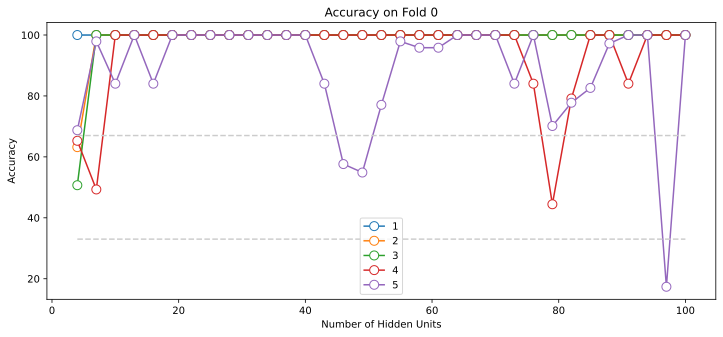

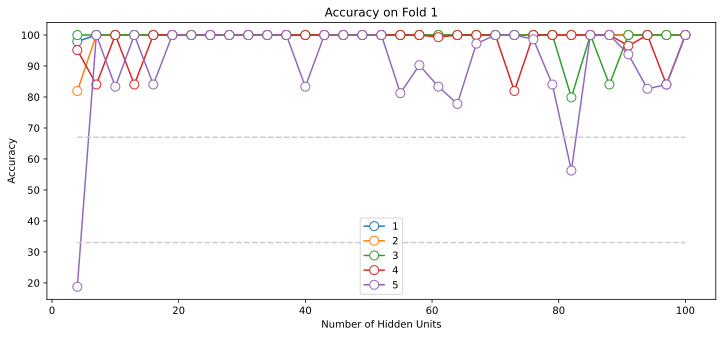

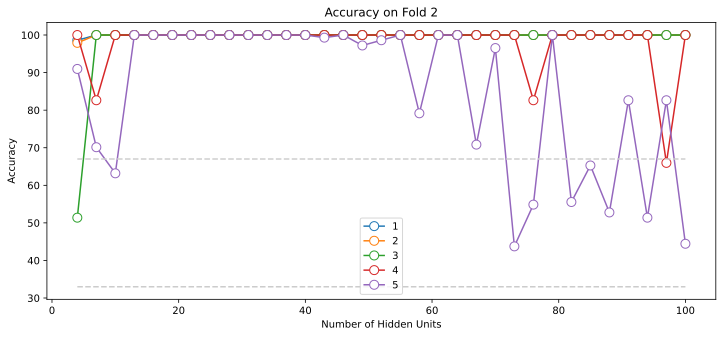

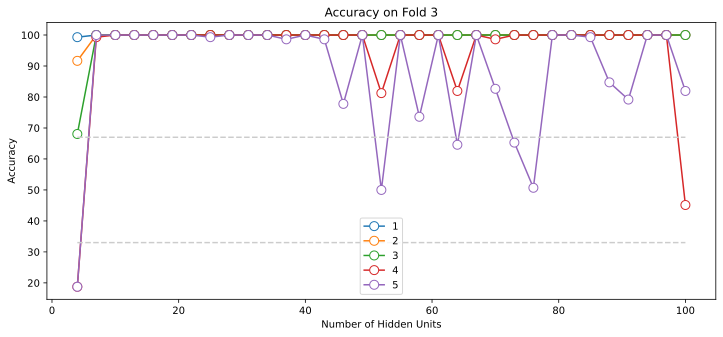

In [ ]:
# Aleady selected hypeparameters
learning_rate = 0.05
epochs = 350
optimizer = 'Adam'
# No mini-Batch needed, take whole training set

# Define the model parameters: number of layers and number of units per layer.
numlayers = range(1, 6)  # Number of hidden layers.
numunits = np.arange(4, 101, 3)  # Units per hidden layer.


# Apply K-Flod CV for the training process
for foldi, (train_index, dev_index) in enumerate(kf.split(train_data)):

    # X is feature matrix, y is label vector, dev is validation set
    X_train, X_dev = train_data[train_index], train_data[dev_index]
    y_train, y_dev = train_labels[train_index], train_labels[dev_index]
    # transform to data loader
    train_loader, test_loader = dataLoaderCovert(X_train, y_train, X_dev, y_dev, X_train.shape[0])

    # Initialize matrices to store accuracies and total parameters.
    accuracies = np.zeros((len(numunits), len(numlayers)))

    # Start the experiment by varying the number of units and layers.
    for unitidx in range(len(numunits)):
        for layeridx in range(len(numlayers)):

            # Build the model
            netHidden, lossFuncDemo, optimizerDemo = customNet(
                numunits[unitidx], numlayers[layeridx], nVar, nClasses, optimizer, learning_rate)

            # Train the model
            _, _, _, trainedNetHidden = trainNet(
                netHidden, lossFuncDemo, optimizerDemo, train_loader, test_loader, epochs)

            # Get overal accuracy
            trainAccH, _ = finalAcc(trainedNetHidden, X_train, y_train, X_dev, y_dev)

            # Train the model and store the results.
            accuracies[unitidx, layeridx] = trainAccH

    # Show accuracy as a function of the number of hidden units for different layers.
    fig, ax = plt.subplots(1, figsize=(12, 5))

    ax.plot(numunits, accuracies, 'o-', markerfacecolor='w', markersize=9)
    ax.plot(numunits[[0, -1]], [33, 33], '--', color=[0.8, 0.8, 0.8])
    ax.plot(numunits[[0, -1]], [67, 67], '--', color=[0.8, 0.8, 0.8])
    ax.legend(numlayers)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Number of Hidden Units')
    ax.set_title(f'Accuracy on Fold {foldi}')
    plt.show()

### 4. Final train with selected hyperparameters

Selected hyperparameters after fine tuning:  
Optimizer = Adam, lr = 0.05 epochs = 350; batchSize = one batch; number of hidden layer = 1; number of neueons = 32  

The final accuracy of training ANN model on Fold 3 is 100.00%
The final accuracy of testing ANN model on Fold 3 is 100.00%


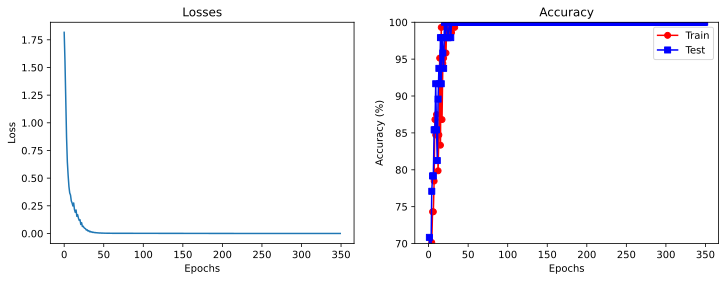

In [ ]:
# Selected hyperparameters
# optimizer = 'Adam'
learning_rate = 0.05
epochs = 350
nLayers = 1
nUnits = 32

# Find best performance model
bestTestAcc = 0

# Apply K-Flod CV for the training process
for foldi, (train_index, dev_index) in enumerate(kf.split(train_data)):

    # X is feature matrix, y is label vector, dev is validation set
    X_train, X_dev = train_data[train_index], train_data[dev_index]
    y_train, y_dev = train_labels[train_index], train_labels[dev_index]
    # transform to data loader
    train_loader, test_loader = dataLoaderCovert(X_train, y_train, X_dev, y_dev, X_train.shape[0])

    # Build the model
    net, lossFunc, optimizer = customNet(nUnits, nLayers, nVar, nClasses, 'Adam', learning_rate)

    # Train the model
    trainAcc, testAcc, losses, trainedNet = trainNet(net, lossFunc, optimizer, train_loader, test_loader, epochs)

    # Get overal accuracy
    finTrainAcc, finTestAcc = finalAcc(trainedNet, X_train, y_train, X_dev, y_dev)

    # Model selection based on test accuracy
    if finTestAcc > bestTestAcc:
        bestTestAcc = finTestAcc
        bestTrainAcc = finTrainAcc
        ongoingTrainAcc = trainAcc
        ongoingTestAcc = testAcc
        nfold = foldi
        best_model_state_dict = trainedNet.state_dict()

# Results
print(f"The final accuracy of training ANN model on Fold {foldi} is {bestTrainAcc:.2f}%")
print(f"The final accuracy of testing ANN model on Fold {foldi} is {bestTestAcc:.2f}%")

# Plot results
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(losses)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([70,100])
plt.show()

### 5. Final evaluation on reserved test set

In [ ]:
# Load final ANN model
# Recreate the model
finalNet, _, _ = customNet(nUnits, nLayers, nVar, nClasses, 'Adam', learning_rate)
# Load the best state dictionary
finalNet.load_state_dict(best_model_state_dict)

# Final tesing on reseved test dataset
final_predictions = finalNet(test_data_reserved)
final_predlabels = tc.argmax(final_predictions, axis=1)
final_test_accuracy = 100 * tc.mean((final_predlabels == test_labels_reserved).float())

# Final tesing on entire dataset
totScaledDdata = tc.cat((train_data, test_data_reserved), 0)
totLabels = tc.cat((train_labels, test_labels_reserved), 0)

final_predictions_whole = finalNet(test_data_reserved)
final_predlabels_whole = tc.argmax(final_predictions_whole, axis=1)
final_accuracy_whole = 100 * tc.mean((final_predlabels_whole == test_labels_reserved).float())

print(f"The final test accuracy of the ANN model, based on the reserved testing set, is {final_test_accuracy:.2f}%")
print(f"The final test accuracy of the ANN model, based on the entire dataset, is {final_accuracy_whole:.2f}%")
